In [1]:
from fastai.vision.all import *
import torchvision

def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 

random_seed(42,True)
path=Path("/kaggle/input/lfw-yyy2-lbq")
files=get_image_files(path)
import wandb
wandb.login(key='1b23517e0f9e52312f9554d602fdf4de1b98a8f4')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img
    
def gray(img):
    if isinstance(img, PILImage):
        img1=img.convert("L")
        return img1
    else:
        return img

In [3]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same
    
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)
    
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],bs=16)

#*aug_transforms()
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x1 = self.head(x1)
        x2 = self.head(x2)
        return x1, x2

In [4]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

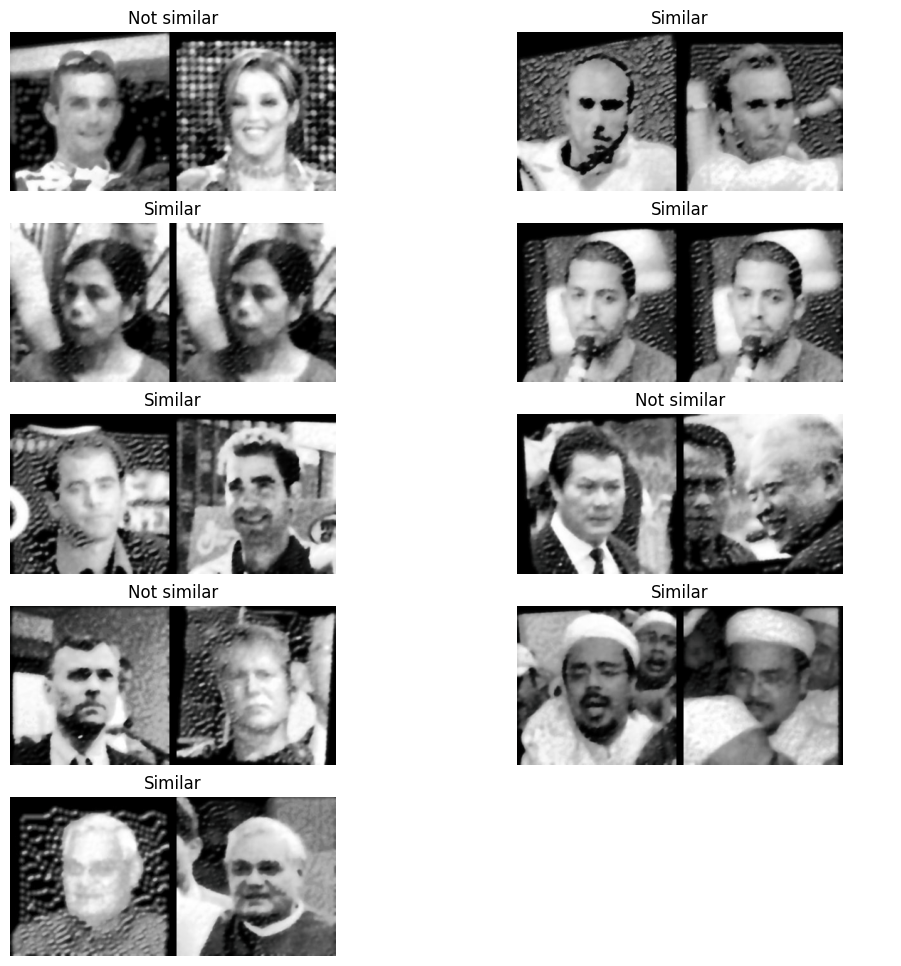

In [5]:
dls.show_batch()

In [6]:
EffNet=efficientnet_v2_m(weights="DEFAULT")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(EffNet, cut=-2)
head = create_head(1280, 256, [1024, 512], 0.5, bn_final=True)
model = SiameseModel(encoder, head)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 147MB/s]


In [7]:
from fastai.optimizer import Adam
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist * target
        ndist = dist * (~target)
        loss = 0.5 * ((pdist**2) + (F.relu(self.margin - ndist)**2))
        loss = loss.mean() if size_average else loss.sum()
        return loss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]
           

def contrastive_accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold).float()
    return (preds == targets).float().mean()

def accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    true_negatives = torch.sum((preds == 0) & (targets == 0)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0.0

    return accuracy

def precision(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    return precision

def recall(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return recall

def f1_score(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

class OptimalThreshold:
    def __init__(self, start=0.1, end=4.0, step=0.01):
        self.start = start
        self.end = end
        self.step = step
        self.best_threshold = None

    def find(self, preds, targets):
        best_accuracy = 0.0
        for threshold in np.arange(self.start, self.end, self.step):
            preds_thresholded = (preds < threshold).float()
            accuracy = (preds_thresholded == targets).float().mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_threshold = threshold
                
class PrintBestThreshold(Callback):
    def after_epoch(self):
        print(f"Epoch {self.learn.epoch} LR:{self.opt.hypers[0]['lr']:.10f} Best threshold: {optimal_threshold.best_threshold:.2f}")

optimal_threshold = OptimalThreshold()

from fastai.callback.wandb import *
# start logging a wandb run
wandb.init(project="lfw", name='effv2M')
# To log only during one training phase
# To log continuously for all training phases
learn = Learner(dls, model, loss_func=ContrastiveLoss(margin=2.5), opt_func=Adam,
                splitter=siamese_splitter, metrics=[accuracy, precision, recall, f1_score],cbs=[WandbCallback(),PrintBestThreshold()])

wandb: Currently logged in as: kennys. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240403_100256-0tldn8i4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run effv2M
wandb: ⭐️ View project at https://wandb.ai/kennys/lfw
wandb: 🚀 View run at https://wandb.ai/kennys/lfw/runs/0tldn8i4


In [8]:
#learn.lr_find()

In [9]:
learn.freeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,10.742540,4.720906,0.805367,0.939180,0.661157,0.746416,04:25
1,2.187823,2.081533,0.843537,0.933316,0.747194,0.806953,04:23
2,2.114764,2.059099,0.864324,0.929673,0.791998,0.837491,04:24
3,2.097847,1.972525,0.895692,0.942251,0.842813,0.878124,04:24
4,2.041288,1.953990,0.903250,0.947234,0.850230,0.884593,04:24
5,1.930985,1.918667,0.914588,0.952596,0.870021,0.898463,04:23
6,2.018940,1.918145,0.915722,0.954534,0.871231,0.898999,04:24
7,1.948717,1.890859,0.921769,0.952871,0.888768,0.913108,04:24
8,2.035550,1.885803,0.927060,0.957712,0.892248,0.917548,04:24
9,1.912845,1.893673,0.928949,0.957136,0.897128,0.919921,04:24


Epoch 0 LR:0.0037080426 Best threshold: 0.10
Epoch 1 LR:0.0090779107 Best threshold: 0.10
Epoch 2 LR:0.0098913969 Best threshold: 0.44
Epoch 3 LR:0.0090469562 Best threshold: 0.53
Epoch 4 LR:0.0075027682 Best threshold: 0.10
Epoch 5 LR:0.0055258388 Best threshold: 0.10
Epoch 6 LR:0.0034579946 Best threshold: 0.10
Epoch 7 LR:0.0016567854 Best threshold: 0.10
Epoch 8 LR:0.0004336583 Best threshold: 0.10
Epoch 9 LR:0.0000001010 Best threshold: 0.10
WandbCallback was not able to get prediction samples -> wandb.log must be passed a dictionary


In [10]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,1.965697,1.885254,0.928193,0.956372,0.896041,0.919086,06:42
1,1.967035,1.870561,0.929327,0.955728,0.896223,0.919557,06:40
2,1.920516,1.877264,0.932351,0.957667,0.901301,0.921782,06:38
3,1.932698,1.869337,0.931973,0.959862,0.900259,0.922287,06:38
4,1.985421,1.866641,0.932729,0.957876,0.904564,0.924782,06:40
5,1.915473,1.865498,0.934618,0.960035,0.905939,0.926248,06:42
6,1.964942,1.846359,0.945956,0.965722,0.923794,0.939719,06:39
7,1.962990,1.844401,0.943689,0.969946,0.909998,0.933397,06:38
8,1.972888,1.839618,0.946334,0.967015,0.922307,0.939005,06:40
9,1.903902,1.826046,0.951625,0.967063,0.932944,0.944677,06:39


Epoch 0 LR:0.0000013140 Best threshold: 0.10
Epoch 1 LR:0.0000037124 Best threshold: 0.10
Epoch 2 LR:0.0000066789 Best threshold: 0.10
Epoch 3 LR:0.0000090806 Best threshold: 0.73
Epoch 4 LR:0.0000100000 Best threshold: 0.93
Epoch 5 LR:0.0000098911 Best threshold: 0.77
Epoch 6 LR:0.0000095684 Best threshold: 0.72
Epoch 7 LR:0.0000090460 Best threshold: 0.53
Epoch 8 LR:0.0000083468 Best threshold: 0.88
Epoch 9 LR:0.0000075014 Best threshold: 1.00
Epoch 10 LR:0.0000065466 Best threshold: 0.99
Epoch 11 LR:0.0000055243 Best threshold: 0.97
Epoch 12 LR:0.0000044790 Best threshold: 0.97
Epoch 13 LR:0.0000034565 Best threshold: 0.91
Epoch 14 LR:0.0000025014 Best threshold: 0.88
Epoch 15 LR:0.0000016556 Best threshold: 0.79
Epoch 16 LR:0.0000009559 Best threshold: 0.87
Epoch 17 LR:0.0000004330 Best threshold: 0.87
Epoch 18 LR:0.0000001097 Best threshold: 0.81
Epoch 19 LR:0.0000000001 Best threshold: 0.86


In [11]:
learn.export('EffNet_V2_M_nExt_Filtter_256Emb.pkl')
#learn = load_learner('resnet50_lfw_gray.pkl', cpu=False)